# Emotion Classification Using Stacking Classifier with Hyperparameter-Tuned Base Models

In this Colab notebook, we implement an advanced **Stacking Classifier** to classify emotions in a balanced, augmented dataset. By leveraging **hyperparameter tuning** for base models and combining their predictions through a meta-classifier, we aim to enhance model performance and achieve robust generalization.

### Key Highlights:
1. **Dataset Splitting:**
   - The dataset is divided into **training** (60%), **validation** (20%), and **testing** (20%) subsets.
   - Training data is used to train and optimize models, validation data for interim evaluation, and test data for final assessment.

2. **TF-IDF Vectorization:**
   - Text data is transformed into numerical features using **TF-IDF Vectorizer**, ensuring that the importance of terms is appropriately captured for machine learning models.

3. **Base Models with Hyperparameter Tuning:**
   - Each base model in the stacking classifier has been fine-tuned:
     - **Logistic Regression**: Optimized with L2 regularization and solver parameters.
     - **Naive Bayes**: Tuned with a smoothing parameter (`alpha`).
     - **Decision Tree**: Configured with `gini` criterion and other splitting thresholds.
     - **Random Forest**: Used with default settings as a robust ensemble method.

4. **Stacking Classifier:**
   - The stacking classifier aggregates predictions from the base models using **Logistic Regression** as the meta-classifier. The `predict_proba` method is used to combine the predicted probabilities from base models.

5. **Performance Evaluation:**
   - The model is evaluated on:
     - **Training data**: To confirm its learning capability.
     - **Validation data**: To ensure generalization during optimization.
     - **Test data**: To measure performance on unseen examples.

6. **Confusion Matrix Analysis:**
   - A confusion matrix visualizes the model's predictions on the test set, offering insights into its classification strengths and weaknesses.

This notebook demonstrates how hyperparameter tuning, combined with a stacking classifier, can improve the predictive performance of emotion classification models.


# Step 1: Import Libraries

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 2: Load the combined dataset

In [ ]:
# Load the augmented dataset
df = pd.read_csv('Augmented_Emotion_Dataset.csv')

# Split the dataset into features and labels
X = df['cleaned_text']
y = df['EMOTION']

# Step 3: Split the Data into Train and Test Sets

In [ ]:
# Split into train, validation, and test sets (60%-20%-20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((141904,), (47301,), (47302,))

# Step 4: Text Vectorization using TF-IDF

In [ ]:
# Vectorize the text data using TF-IDF
tfidf = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# Step 5: Train and Evaluate Models using the augmented balanced dataset

Model saved successfully with joblib.
TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.

--- Training Performance ---
Training Accuracy: 0.9890
Training Classification Report:
               precision    recall  f1-score   support

       anger       0.99      0.99      0.99     12530
     boredom       1.00      1.00      1.00      9899
   confusion       0.99      0.99      0.99     12650
     disgust       1.00      1.00      1.00     13763
        fear       0.99      0.99      0.99     13012
       guilt       0.99      0.99      0.99     13678
         joy       0.97      0.97      0.97     16533
     neutral       0.99      0.99      0.99     12356
     sadness       0.99      0.98      0.99     14313
       shame       0.99      0.99      0.99     12923
    surprise       1.00      1.00      1.00     10247

    accuracy                           0.99    141904
   macro avg       0.99      0.99      0.99    141904
weighted avg       0.99      0.99      0.99    141904


--- Vali

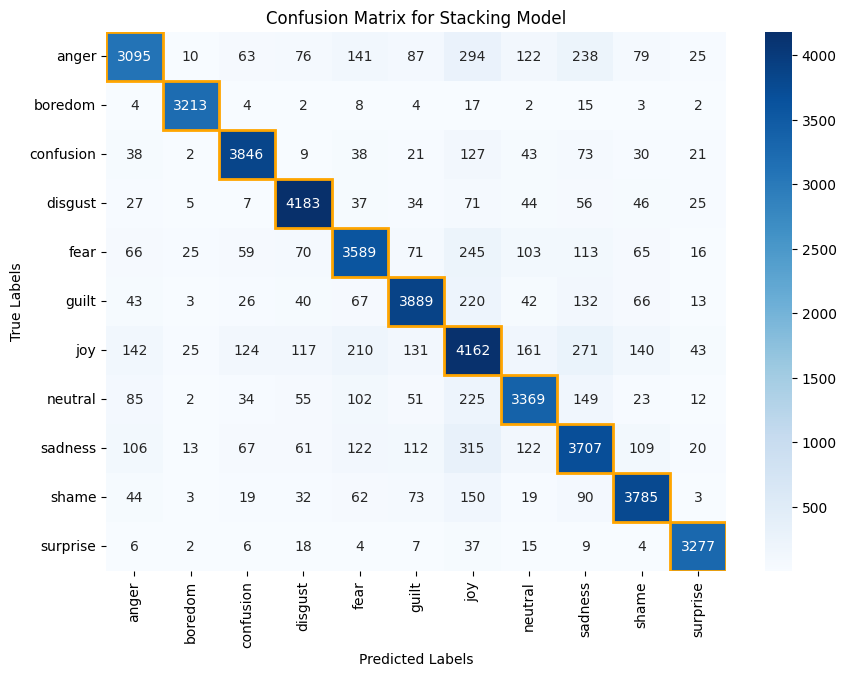

In [ ]:
# Define base models for stacking
base_models = [
    ('log_reg', LogisticRegression(
                C=100,             # Regularization strength (smaller values specify stronger regularization)
                penalty='l2',      # Use L2 regularization
                solver='liblinear' # Algorithm to use in the optimization problem
    )),

    ('naive_bayes', MultinomialNB(alpha=0.5)),  # Set alpha based on best parameter

    ('decision_tree', DecisionTreeClassifier(
      criterion='gini',          # Use 'gini' for the splitting criterion
      max_depth=None,            # No limit on tree depth
      min_samples_leaf=1,        # Minimum samples per leaf node
      min_samples_split=2,       # Minimum samples required to split an internal node
      random_state=42            # Set a random state for reproducibility
    )),

    ('random_forest', RandomForestClassifier(random_state=42))
]

# Define the stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method='predict_proba',
    n_jobs=-1  # Use all available processors
)

# Train the stacking model
stacking_model.fit(X_train_tfidf, y_train)

# Save the stacking model as a pickle file
from joblib import dump, load
dump(stacking_model, 'stacking_model_tuned.joblib')
print("Model saved successfully with joblib.")

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer_tuned.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf, vectorizer_file)
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.")

# Make predictions with the stacking model
y_pred = stacking_model.predict(X_test_tfidf)

# Evaluate the model on the training set
y_train_pred = stacking_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\n--- Training Performance ---")
print(f"Training Accuracy: {train_accuracy:.4f}")
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))

# Evaluate the model on the validation set
y_val_pred = stacking_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("\n--- Validation Performance ---")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluate the model on the testing set
y_test_pred = stacking_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\n--- Testing Performance ---")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print("Testing Classification Report:\n", classification_report(y_test, y_test_pred))

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Highlight the diagonal with a different color
    for i in range(len(cm)):
        plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='orange', lw=2))

    plt.show()

# Plot the confusion matrix for the stacking model
plot_confusion_matrix(y_test, y_test_pred, "Stacking Model", labels=np.unique(y))